In [1]:
import os 
sims = os.listdir('./')
sims = [i for i in sims if 'x' in i]
sims = [i for i in sims if '.txt' not in i]
sims = [i for i in sims if '.pkl' not in i]
simsnames = [i.split('_')[0][1:] for i in sims]



In [5]:
from HeaderP import *
import pynbody as pb
import pynbody.filt as filt
import os, pickle, glob
from itertools import combinations_with_replacement

In [6]:
def readsimdata(simNo,Rcut,Rcut_thread,zcut_thread,disk=True):
    if disk:
        data=pd.read_pickle('./g'+simNo+'_z_0_decomp.pkl')
    else:
        data=pd.read_pickle('./g'+simNo+'_z_0.pkl')
    data['R']=np.sqrt((data['x'])**2+data['y']**2)
    
    if Rcut:
        data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['zbir'])<zcut_thread].reset_index(drop=True)
    data['dR']=data['R']-data['Rbir']
    data['dz']=abs(data['z'])-abs(data['zbir'])
    if disk:
        data = data.loc[(data['decomp']==1)|(data['decomp']==4)].reset_index()
    return data

def normalize_data(data):
    return (data-np.mean(data))/np.std(data)

def train(y, X):
    """
    
    Args:
        y (array): An Nstar array of rotation periods.
        X (array): An Nstar x NX array of features.
        
    Returns:
        weights (array): The array of weights of length NX + 1.
        
    """
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)  # Shape: Nstars x Nfeatures (incl crossterms)
    AT = A.T
    ATA = np.dot(AT, A)
    
    weights = np.linalg.solve(ATA, np.dot(AT, y))
    return weights

In [27]:
def calcRbir_cv(data, fold=5, rescale=True):
    fold = int(fold)
    if rescale:
        args = normalize_data(data['feh']), normalize_data(data['age'])
    else:
        args = data['feh'], data['age']
    args_name = '[Fe/H]', 'τ'
    
    X = list(args)
    X_names = list(args_name)
    
    if rescale:
        for a, b in combinations_with_replacement(args, 2):
            X.append(normalize_data(a * b))
    else:
        for a, b in combinations_with_replacement(args, 2):
            X.append(a * b)

    
    for a, b in combinations_with_replacement(args_name, 2):
        X_names.append(str(a + '*' + b))
        
    X = np.array(X).T


    # Define the number of training and validating stars.
    Ntest = int(1./float(fold)*np.shape(X)[0])
    y = data['Rbir'].values
    ypred = np.zeros(len(y))
    
    shuffle_inds = np.arange(len(y))
    np.random.shuffle(shuffle_inds)
        
    weights = np.zeros((len(X_names)+1, fold))
        
    for i in range(fold):
        if i == fold-1:
            startind = int(-Ntest)
            endind = int(len(shuffle_inds)-1)
        else:
            startind = int(i*Ntest)
            endind = int(Ntest*(i+1))
            
        train_inds = np.append(shuffle_inds[:startind],shuffle_inds[endind:])
        test_inds = shuffle_inds[startind:endind]
        y_train, X_train = y[train_inds], X[train_inds, :]
        y_test, X_test = y[test_inds], X[test_inds, :]

        weights[:, i] = train(y_train, X_train)

        A = np.concatenate((np.ones((len(X_test), 1)), X_test), axis=1)
        #print(np.shape(weights[:, i]))
        y_predict = np.dot(weights[:, i].T, A.T)
        ypred[test_inds] = y_predict

    return np.append(['$θ_C$'],X_names), [np.mean(weights[i,:]) for i in range(len(X_names)+1)], [np.std(weights[i,:]) for i in range(len(X_names)+1)], y, ypred

def calcRstd(data, Rbirbin=np.linspace(0,10,20)):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    for i in range(len(Rbirbin)-1):
        data_loc = data.loc[(data['Rbir']>Rbirbin[i])&(data['Rbir']<Rbirbin[i+1])].reset_index(drop=True)
        Rstds[i] = np.std(data_loc['R']-data_loc['Rbir'])
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def calcRstd_inf(infRbir, trueRbir, Rbirbin=np.linspace(0,10,20)):
    Rbirs = np.zeros(len(Rbirbin)-1)
    Rstds = np.zeros(len(Rbirbin)-1)
    for i in range(len(Rbirbin)-1):
        m = (trueRbir>Rbirbin[i])&(trueRbir<Rbirbin[i+1])
        Rstds[i] = np.std(trueRbir[m]-infRbir[m])
        Rbirs[i] = (Rbirbin[i]+Rbirbin[i+1])/2
    return Rbirs, Rstds

def predNew(weights, data, rescale=True):
    weights = np.array(weights)
    if rescale:
        args = normalize_data(data['feh']), normalize_data(data['age'])
    else:
        args = data['feh'], data['age']
        
    X = list(args)
    if rescale:
        for a, b in combinations_with_replacement(args, 2):
            X.append(normalize_data(a * b))
    else:
        for a, b in combinations_with_replacement(args, 2):
            X.append(a * b)
    X = np.array(X).T
    y = data['Rbir'].values
    A = np.concatenate((np.ones((len(X), 1)), X), axis=1)
    y_predict = np.dot(weights.T, A.T)
    return y, y_predict


Use 6.96e11

Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


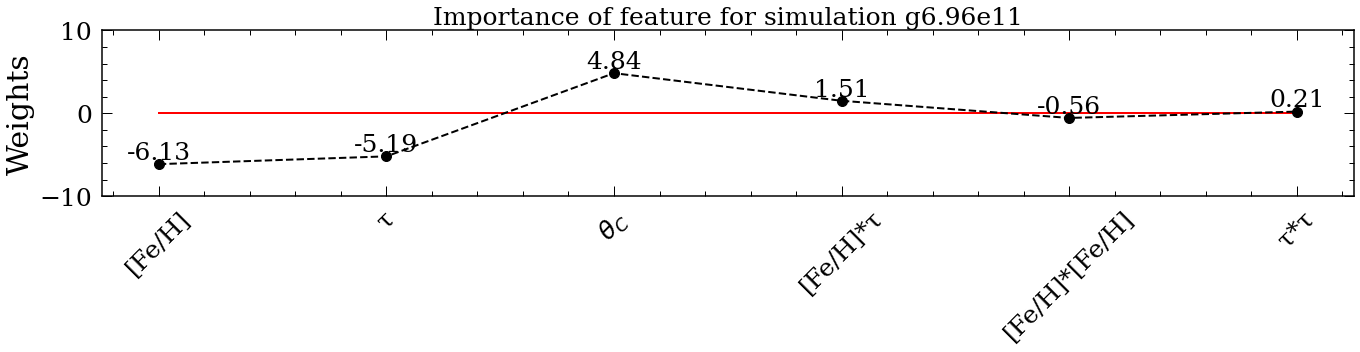

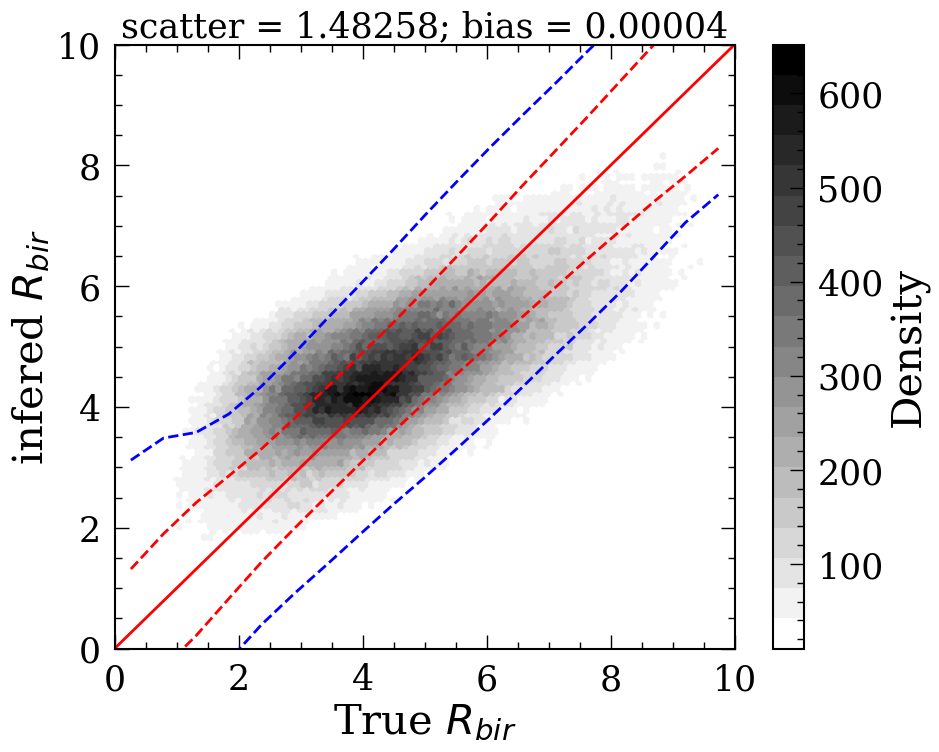

In [31]:
i=0
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.errorbar(range(len(allnames)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames)),np.zeros(len(allnames)),'r-')
plt.xticks(range(len(allnames)), allnames, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-10,10])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(0,10,0,10),gridsize=100, mincnt=10, cmap=cmap)
Rbirs, Rstds = calcRstd(data)
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y)
plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')


  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [00:44<03:42, 44.58s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


 33%|███▎      | 2/6 [01:59<04:09, 62.36s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [04:13<04:45, 95.02s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


 83%|████████▎ | 5/6 [06:50<01:25, 85.84s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


100%|██████████| 6/6 [08:51<00:00, 88.65s/it]


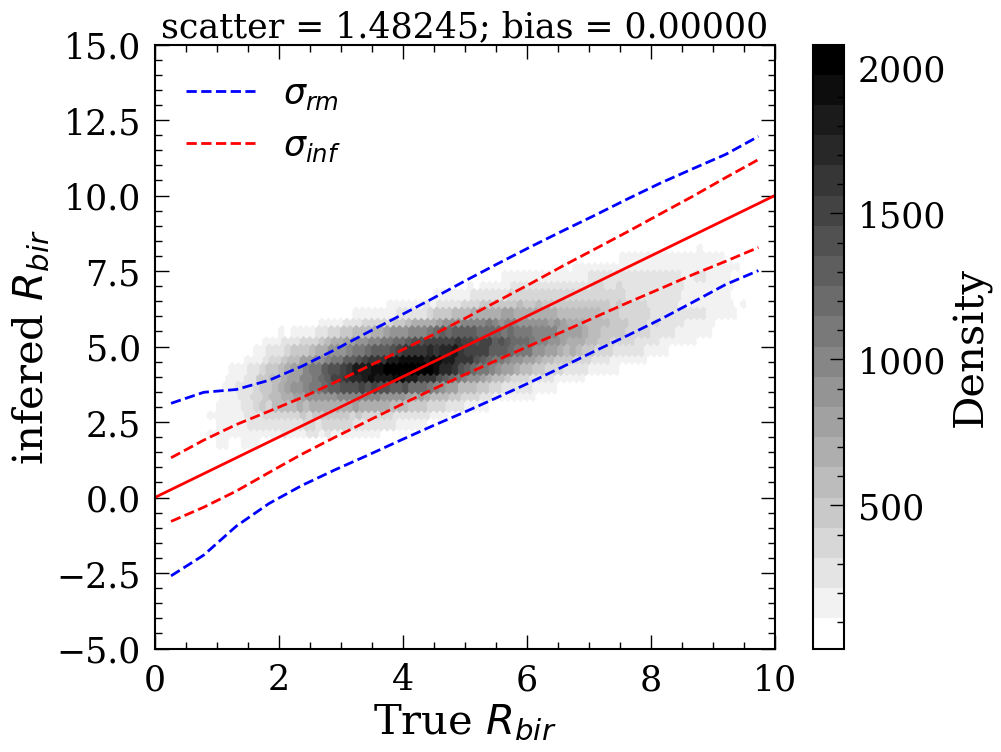

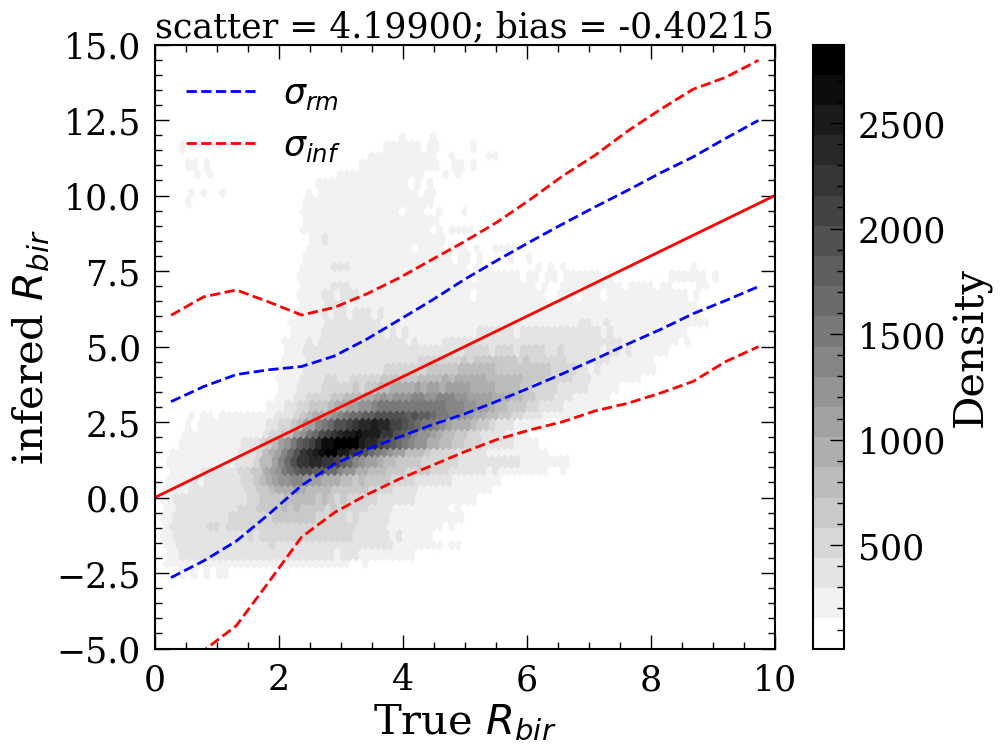

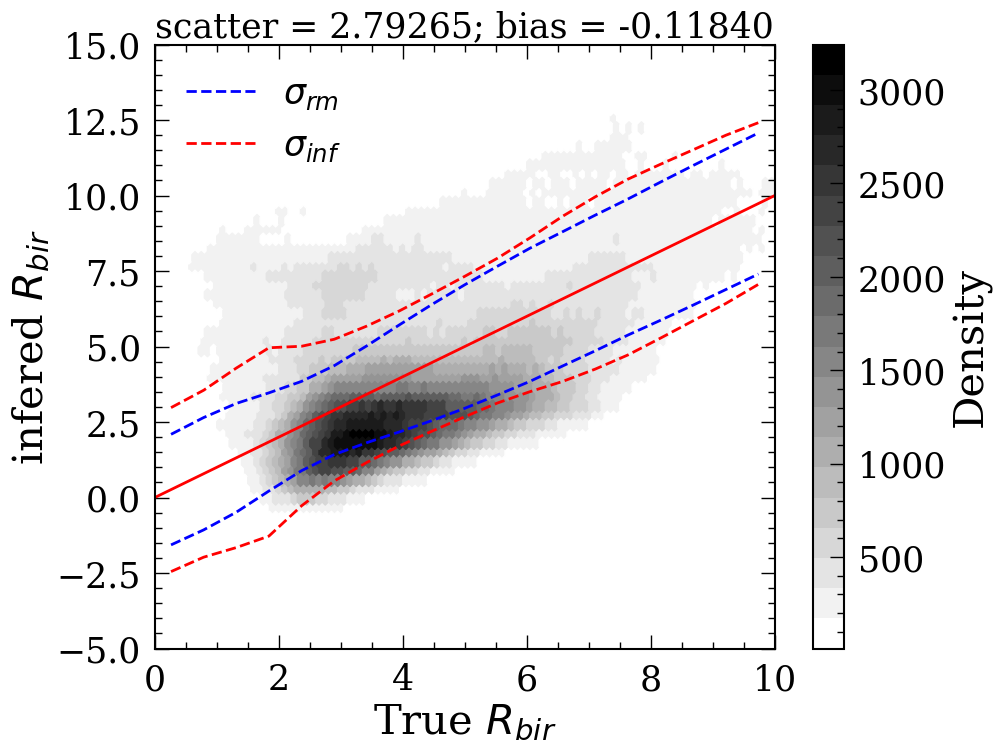

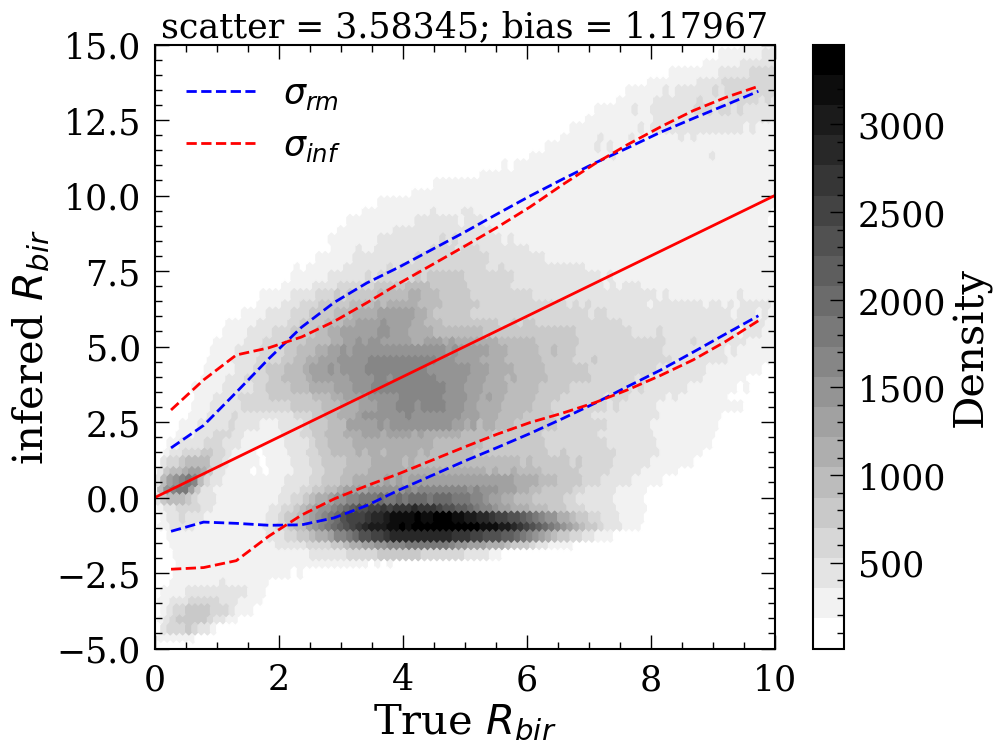

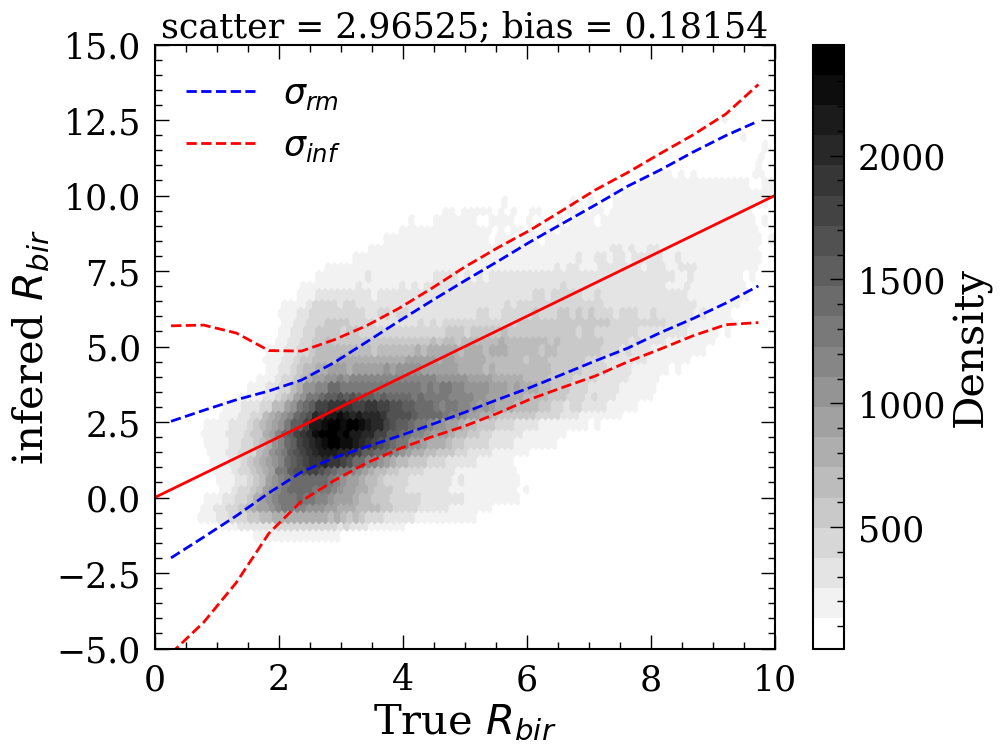

In [32]:
cmap = plt.cm.get_cmap('binary',20)
xs = np.linspace(0, 15, 100)

for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12':
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)
    bias  = np.mean(y-ypred)

    plt.hexbin(y, ypred, extent=(0,10,-20,15),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data)
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y)
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    plt.plot(xs, xs, "r-")
    plt.xlim(0, 10)
    plt.ylim(-5, 15)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model'+simsnames[0]+'.png')
    

Use 8.26e11

Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


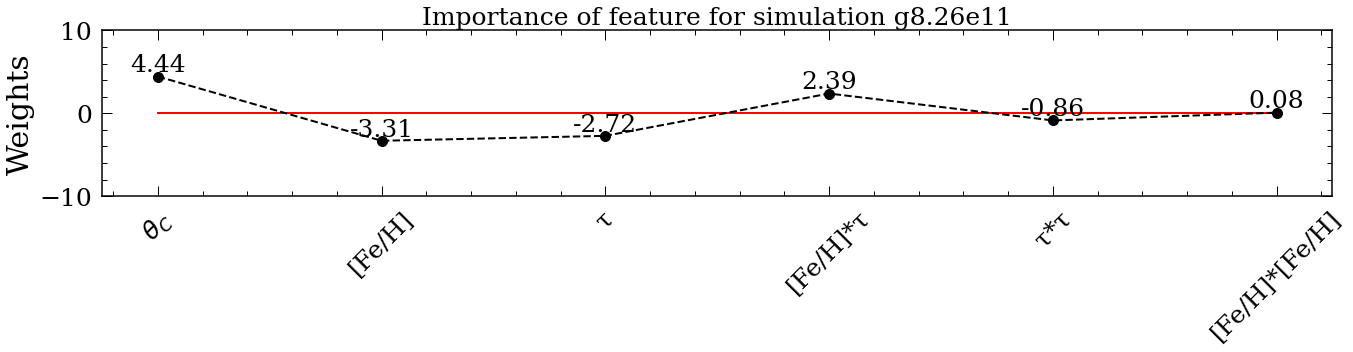

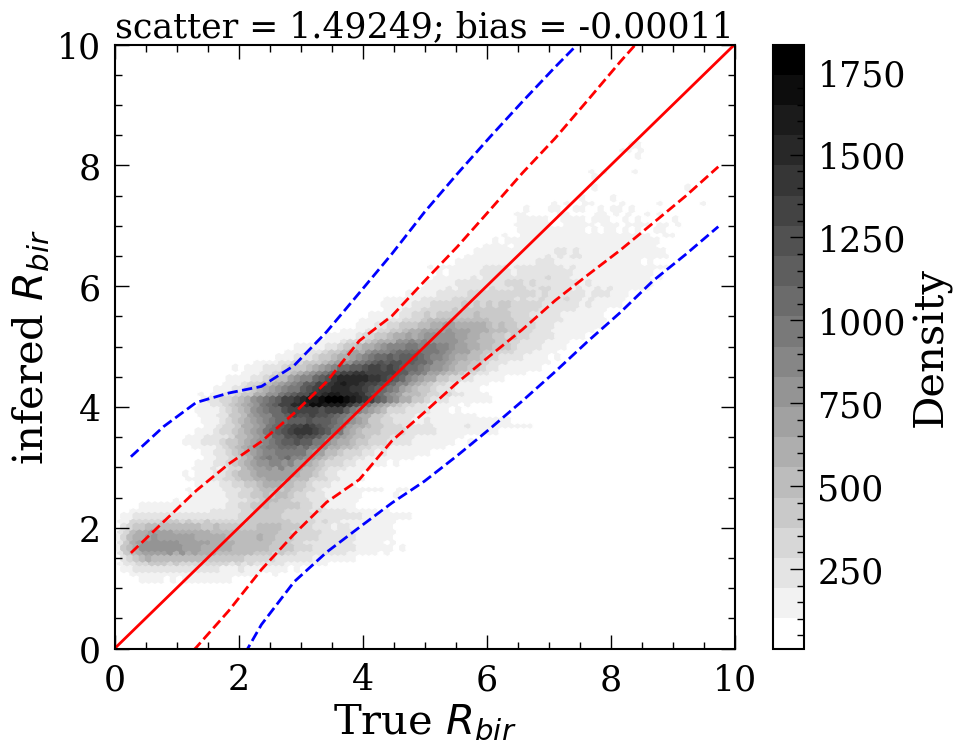

In [34]:
i=1
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.errorbar(range(len(allnames)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames)),np.zeros(len(allnames)),'r-')
plt.xticks(range(len(allnames)), allnames, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-10,10])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(0,10,0,10),gridsize=100, mincnt=10, cmap=cmap)
Rbirs, Rstds = calcRstd(data)
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y)
plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')


  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [00:53<04:27, 53.50s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


 33%|███▎      | 2/6 [02:29<05:13, 78.42s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [04:02<04:14, 84.98s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


 83%|████████▎ | 5/6 [07:07<01:29, 89.45s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


100%|██████████| 6/6 [08:53<00:00, 88.99s/it]


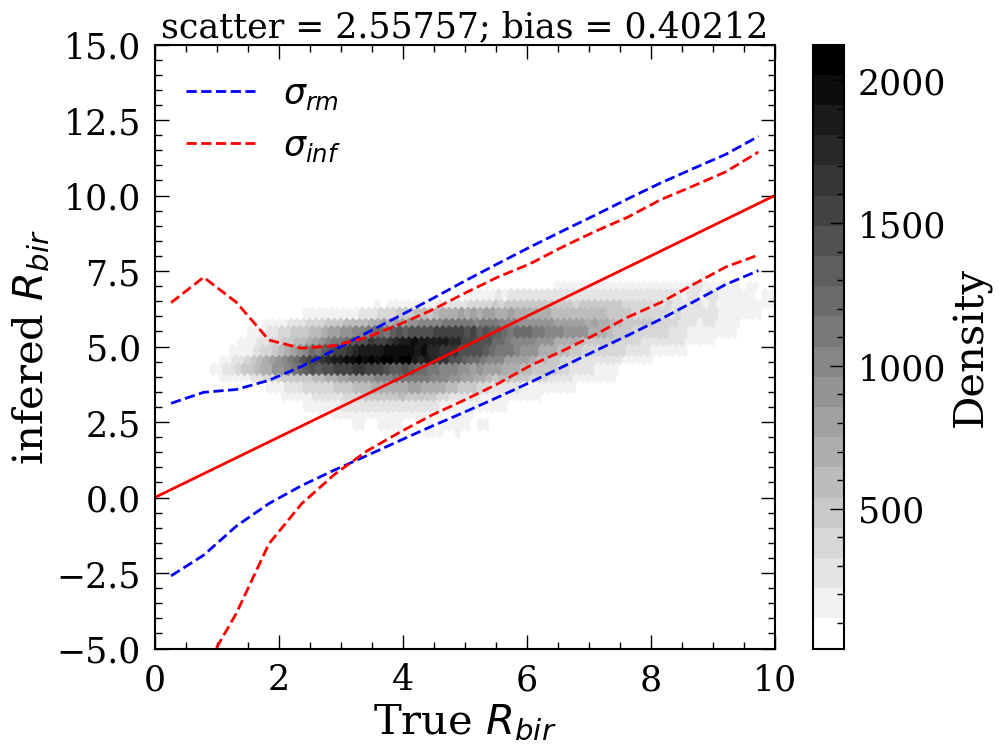

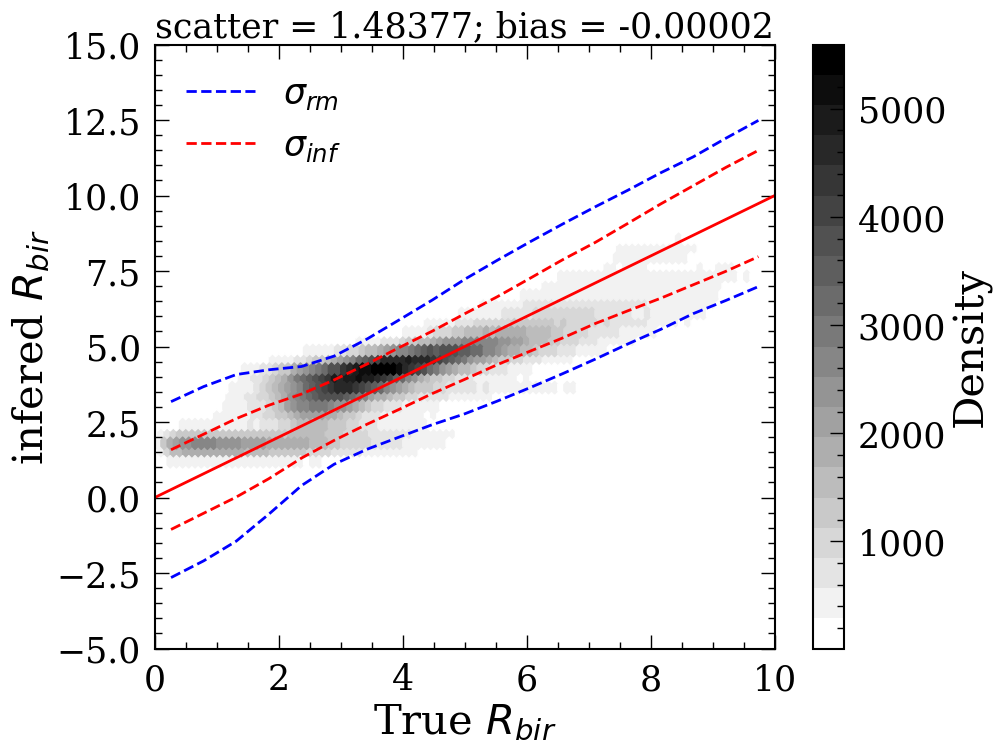

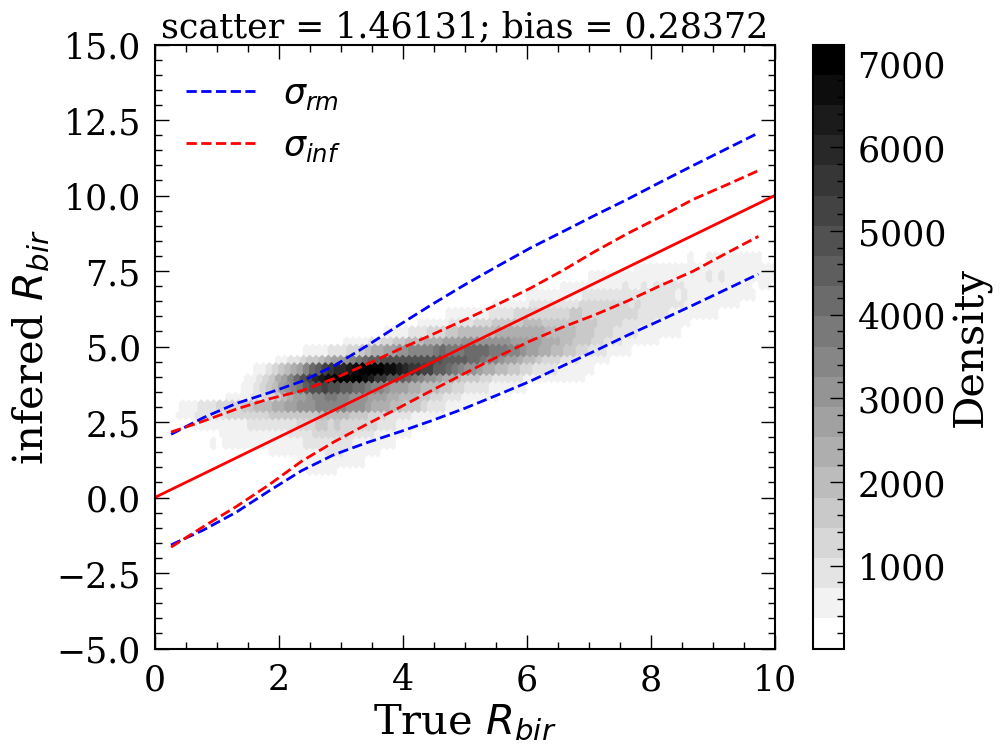

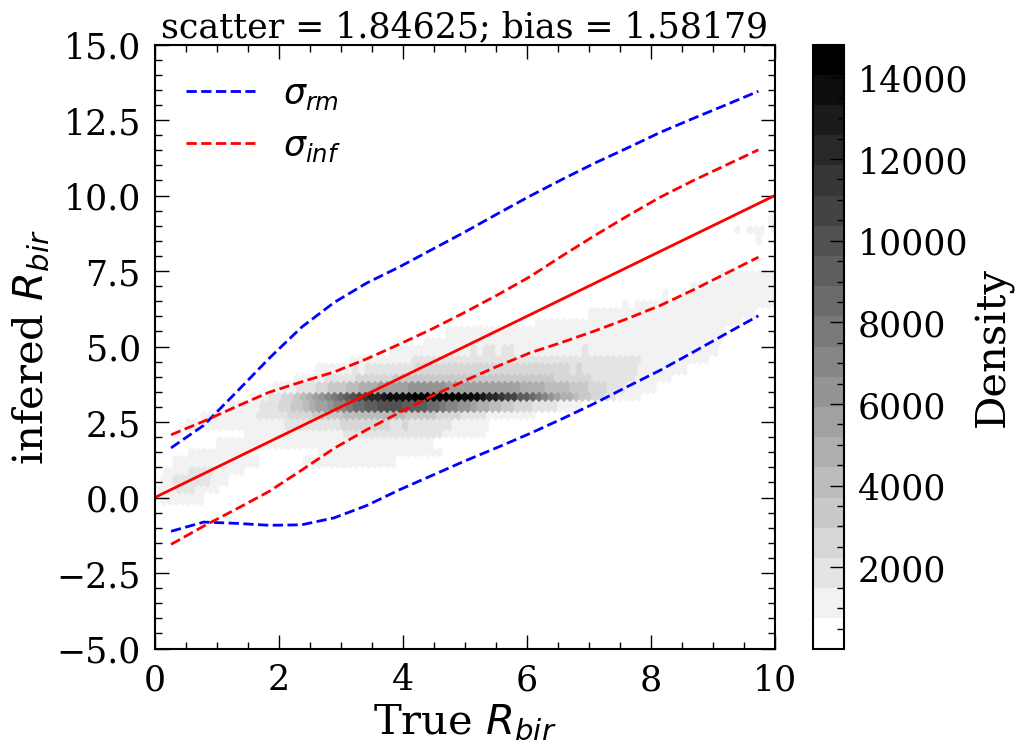

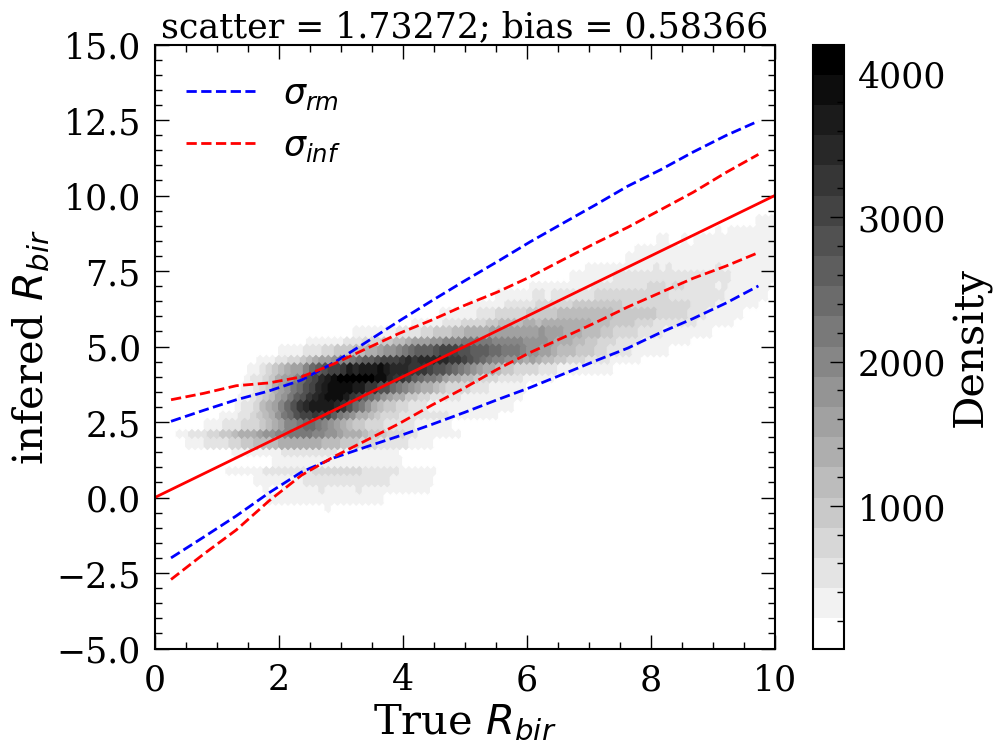

In [35]:
cmap = plt.cm.get_cmap('binary',20)
xs = np.linspace(0, 15, 100)

for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12':
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)
    bias  = np.mean(y-ypred)

    plt.hexbin(y, ypred, extent=(0,10,-20,15),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data)
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y)
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    plt.plot(xs, xs, "r-")
    plt.xlim(0, 10)
    plt.ylim(-5, 15)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model'+simsnames[0]+'.png')
    

Use 7.08e11

Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


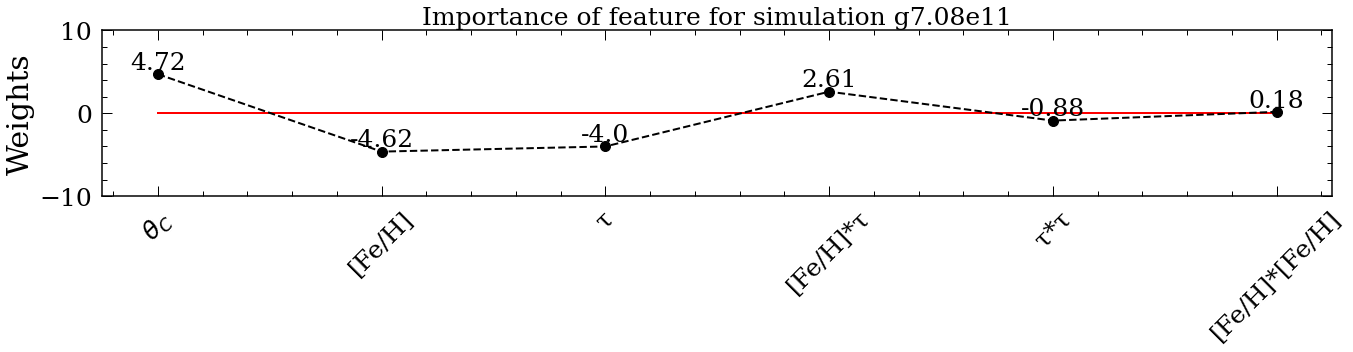

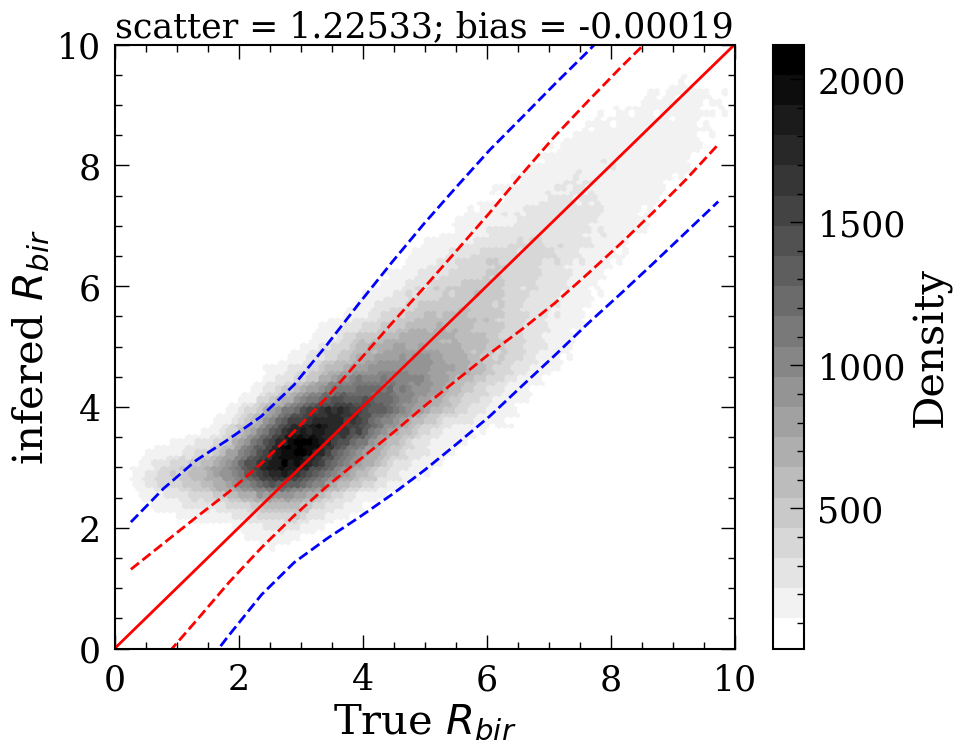

In [36]:
i=2
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.errorbar(range(len(allnames)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames)),np.zeros(len(allnames)),'r-')
plt.xticks(range(len(allnames)), allnames, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-10,10])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(0,10,0,10),gridsize=100, mincnt=10, cmap=cmap)
Rbirs, Rstds = calcRstd(data)
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y)
plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')


  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [01:03<05:19, 63.93s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


 33%|███▎      | 2/6 [02:47<05:48, 87.05s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [05:28<06:02, 120.92s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


 83%|████████▎ | 5/6 [10:09<02:11, 131.95s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


100%|██████████| 6/6 [10:56<00:00, 109.43s/it]


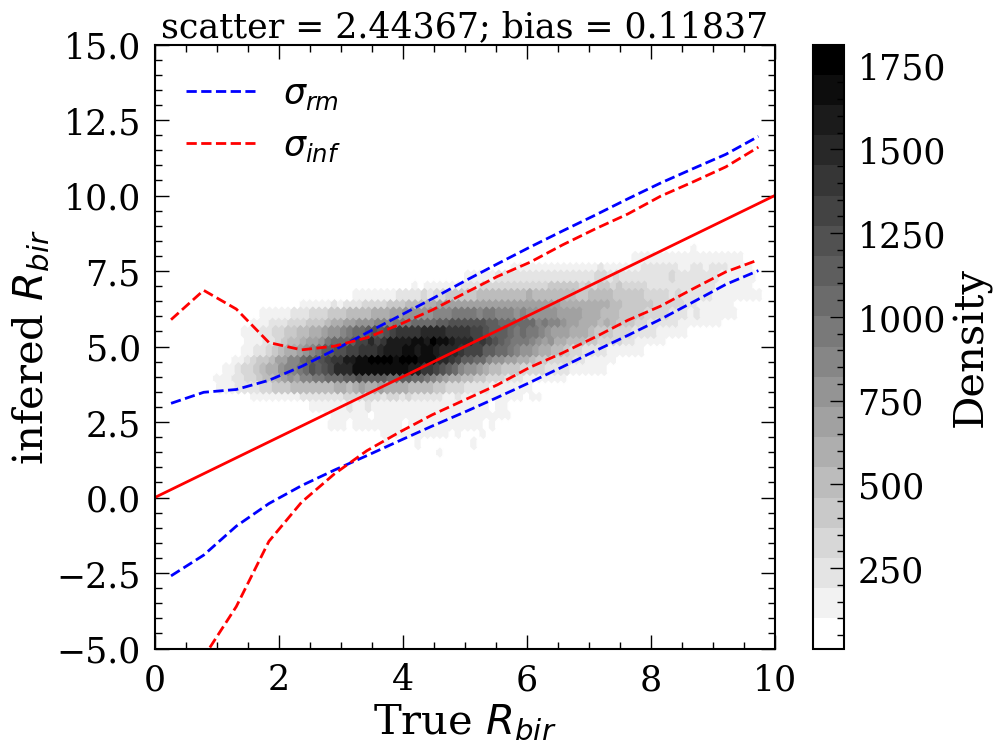

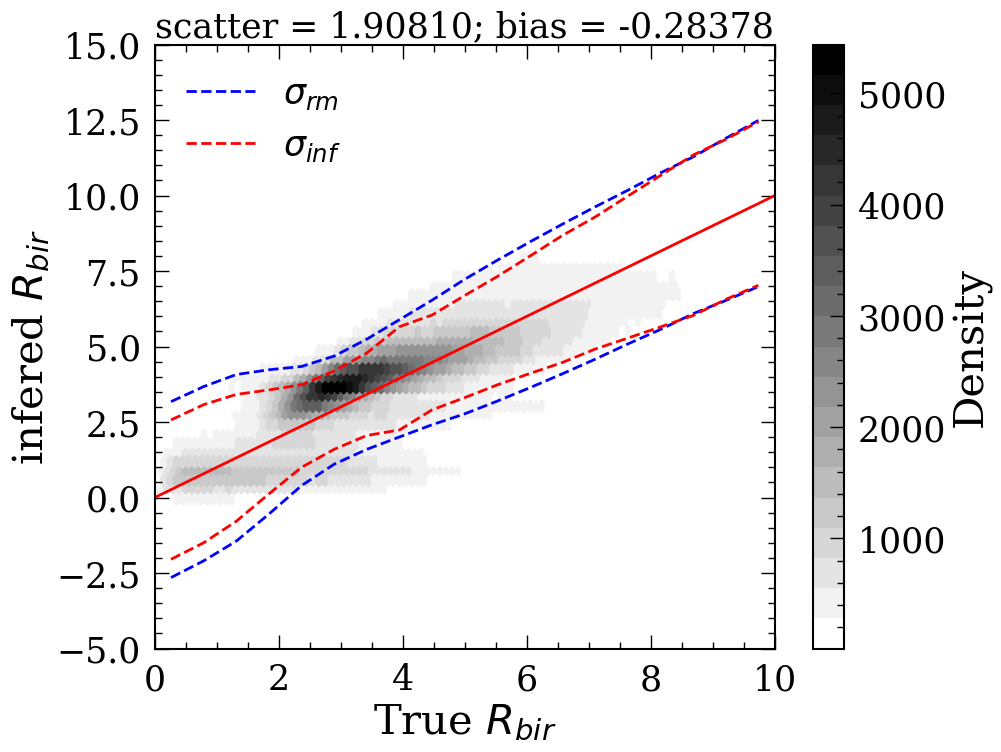

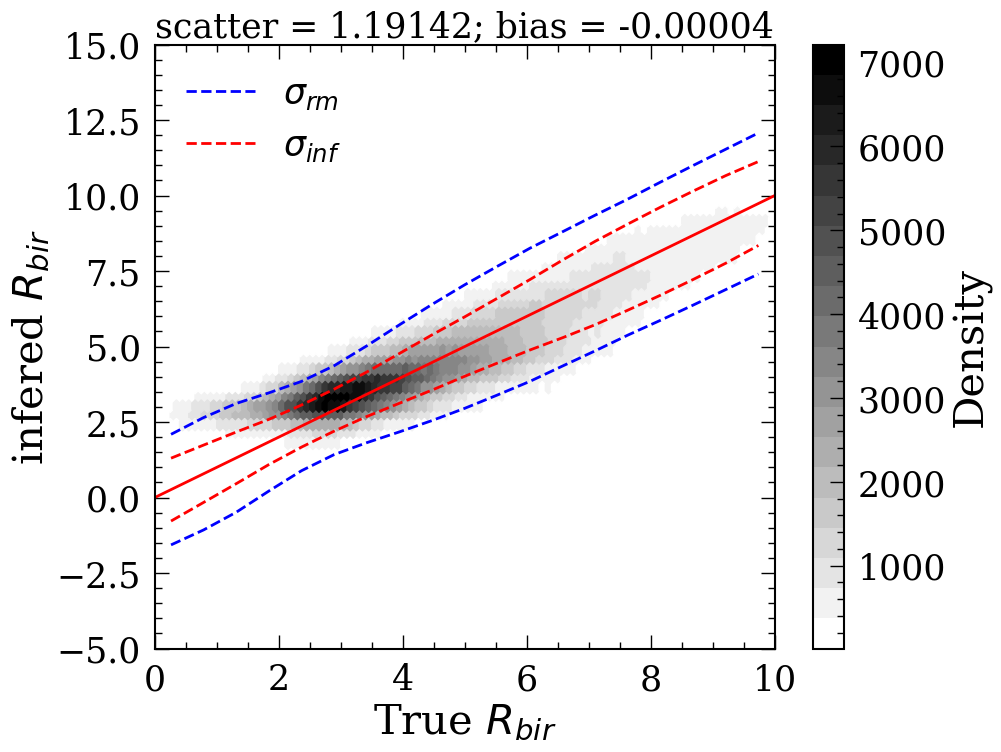

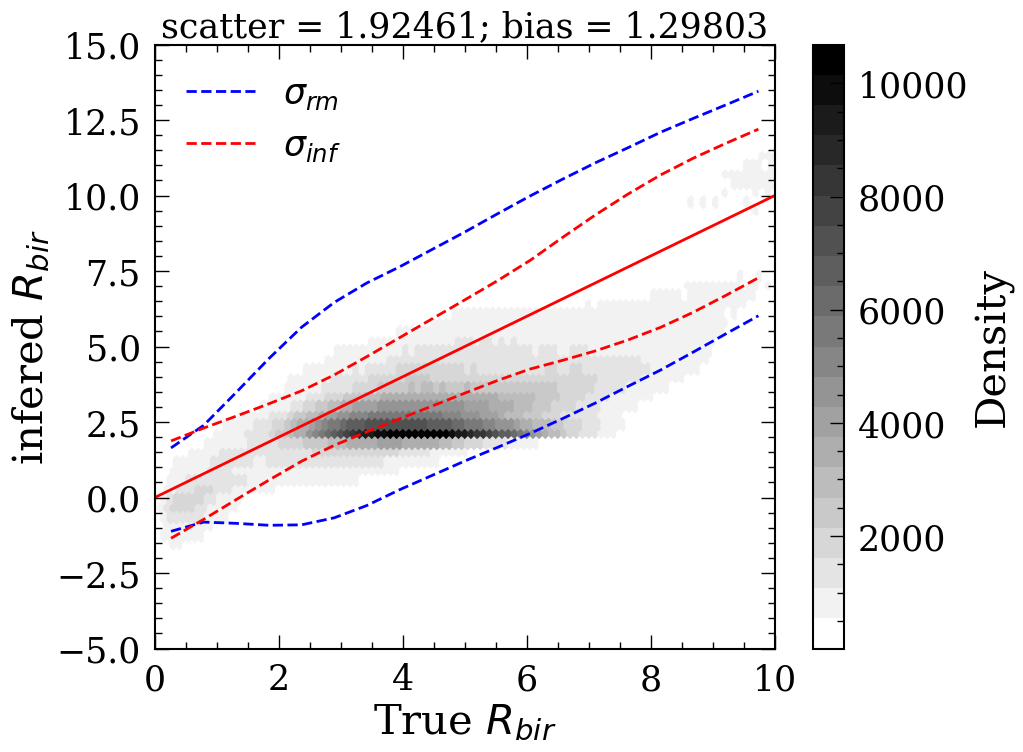

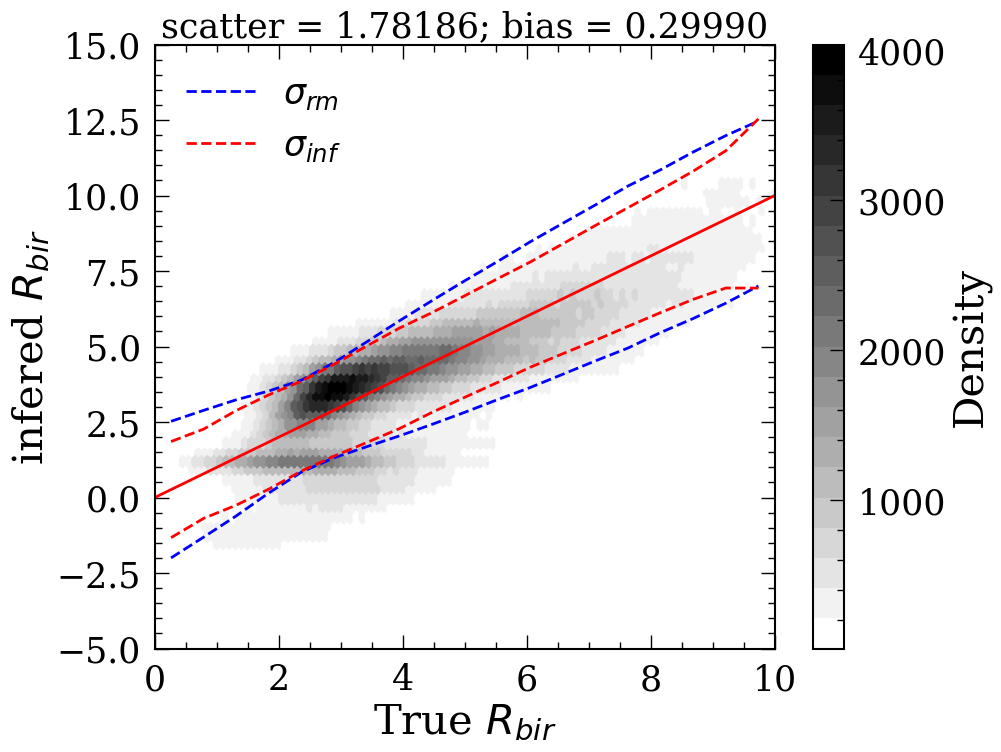

In [37]:
cmap = plt.cm.get_cmap('binary',20)
xs = np.linspace(0, 15, 100)

for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12':
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)
    bias  = np.mean(y-ypred)

    plt.hexbin(y, ypred, extent=(0,10,-20,15),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data)
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y)
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    plt.plot(xs, xs, "r-")
    plt.xlim(0, 10)
    plt.ylim(-5, 15)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model'+simsnames[0]+'.png')
    

Use 2.79e12

Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


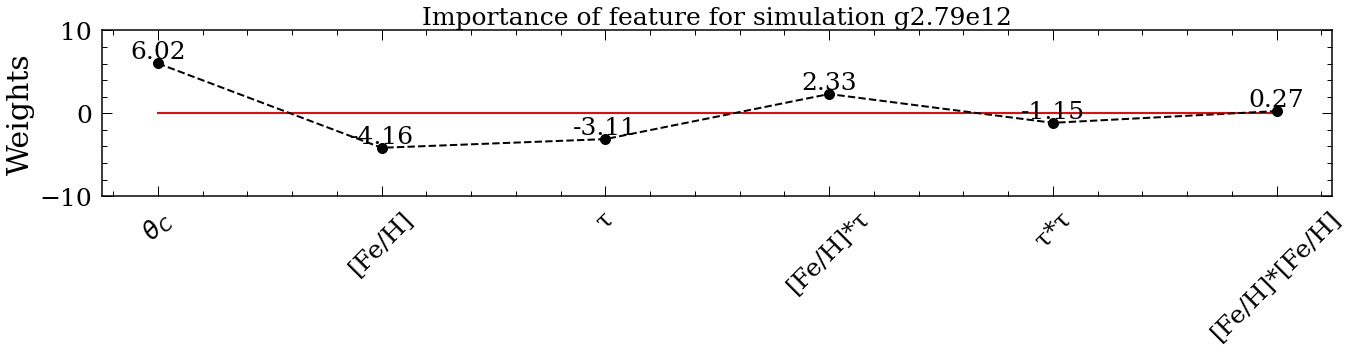

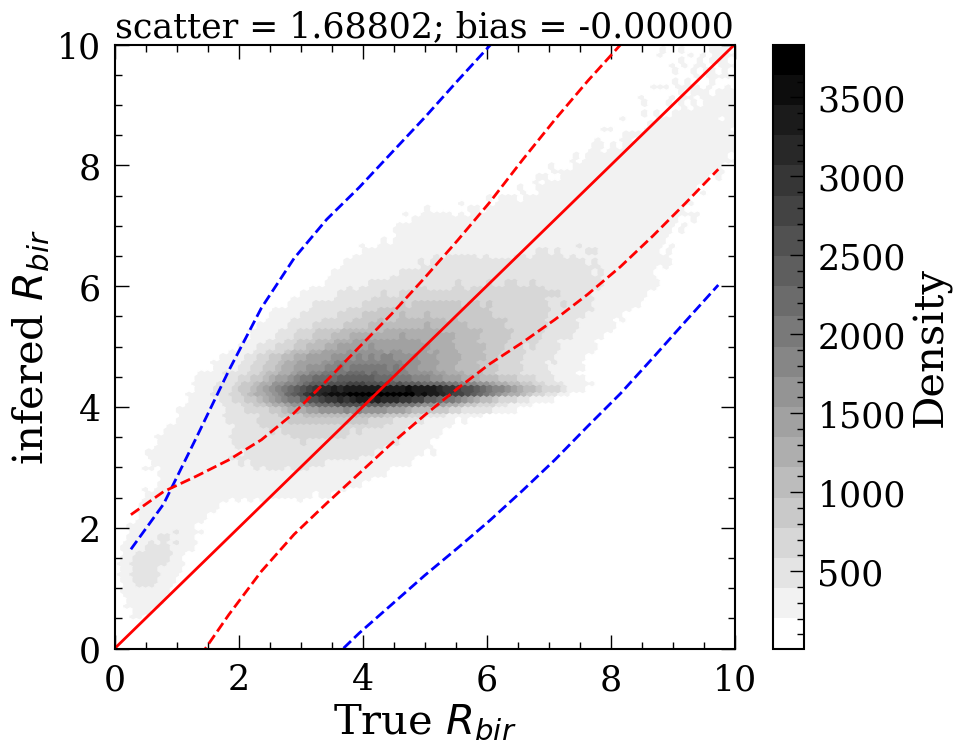

In [38]:
i=-2
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.errorbar(range(len(allnames)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames)),np.zeros(len(allnames)),'r-')
plt.xticks(range(len(allnames)), allnames, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-10,10])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(0,10,0,10),gridsize=100, mincnt=10, cmap=cmap)
Rbirs, Rstds = calcRstd(data)
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y)
plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')


  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [01:11<05:58, 71.66s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


 33%|███▎      | 2/6 [02:49<05:47, 86.80s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [04:44<04:59, 99.99s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


 83%|████████▎ | 5/6 [06:21<01:10, 70.85s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


100%|██████████| 6/6 [07:30<00:00, 75.15s/it]


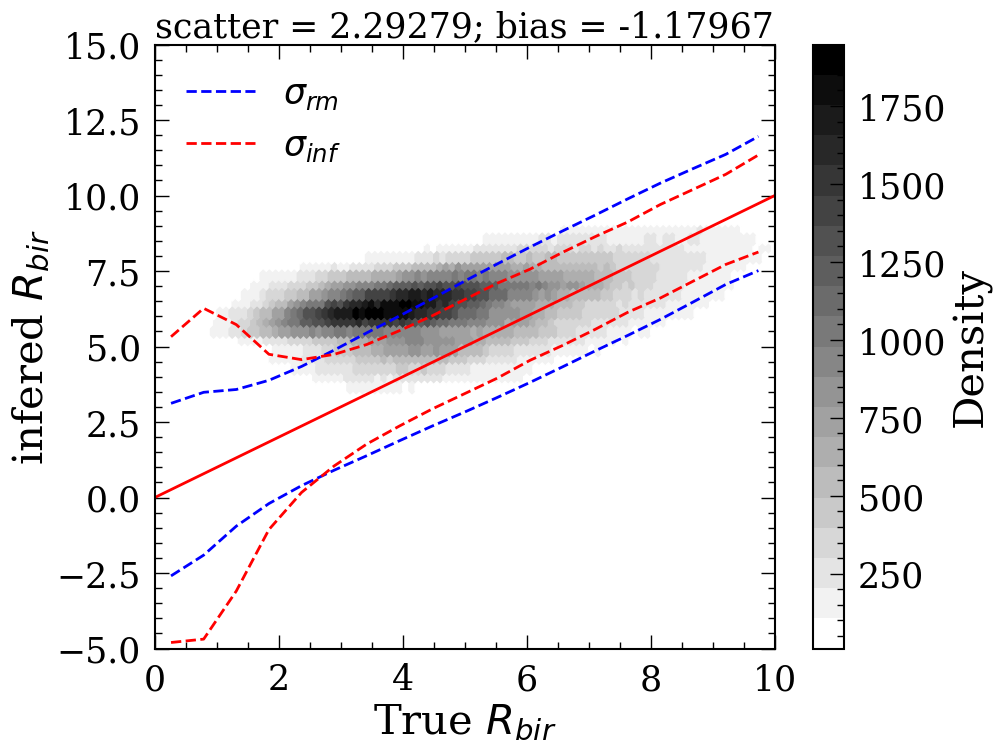

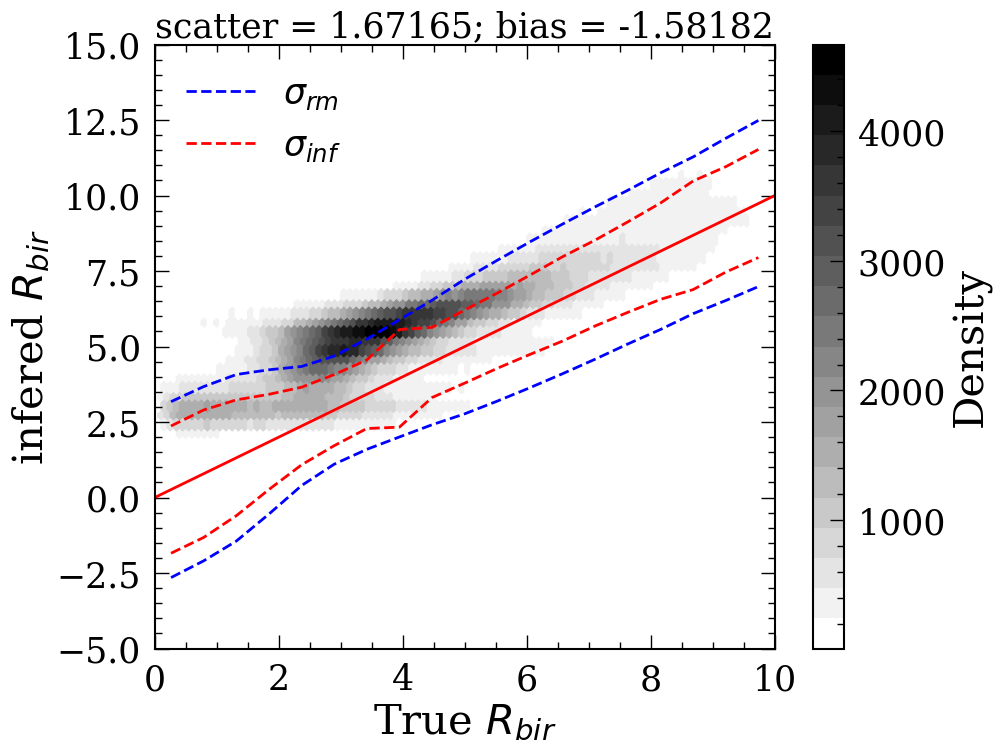

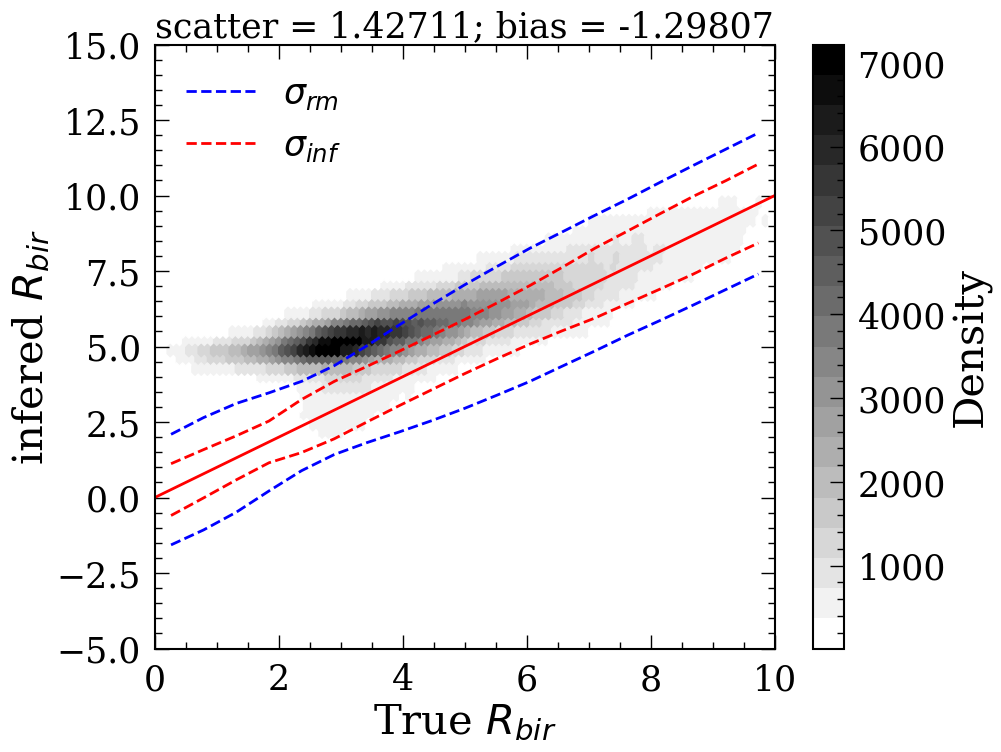

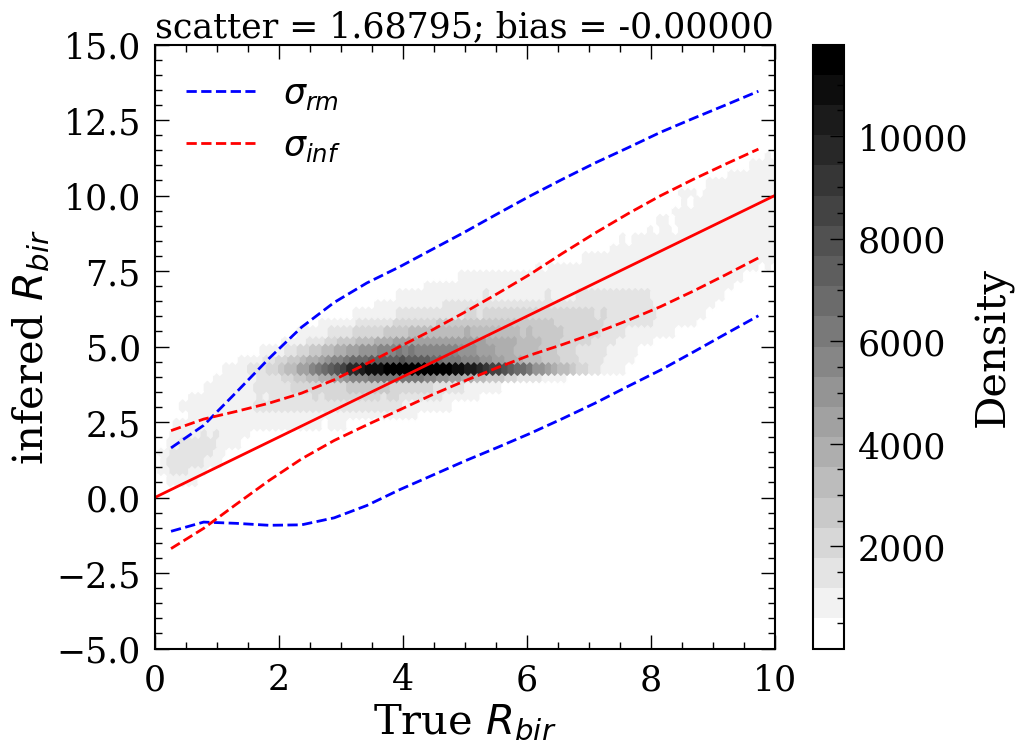

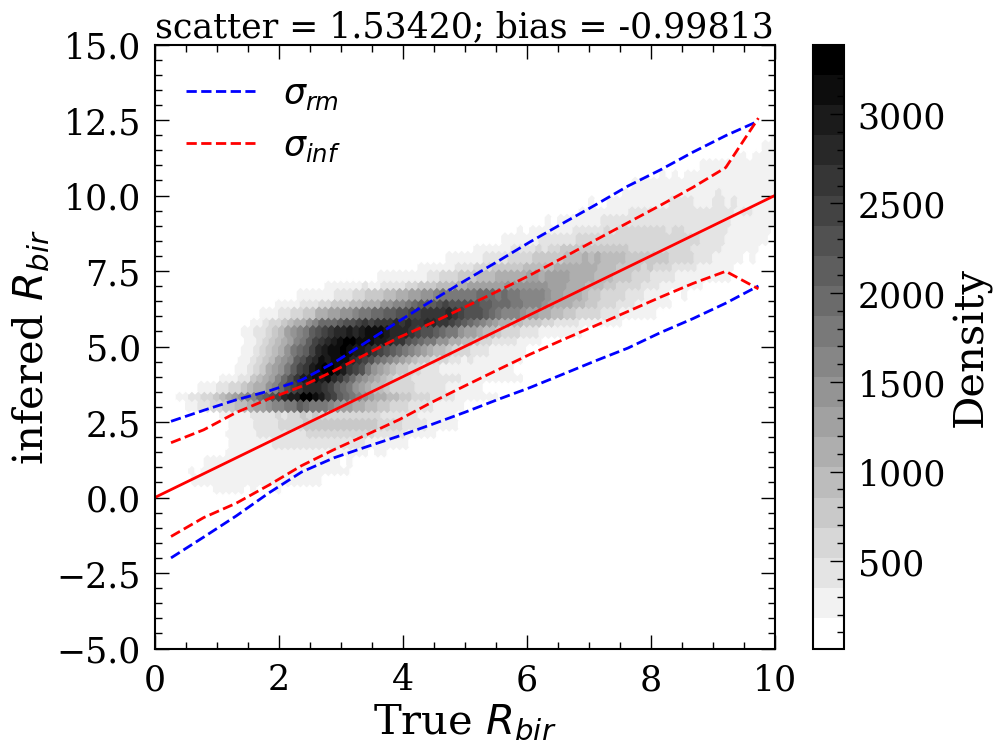

In [39]:
cmap = plt.cm.get_cmap('binary',20)
xs = np.linspace(0, 15, 100)

for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12':
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)
    bias  = np.mean(y-ypred)

    plt.hexbin(y, ypred, extent=(0,10,-20,15),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data)
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y)
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    plt.plot(xs, xs, "r-")
    plt.xlim(0, 10)
    plt.ylim(-5, 15)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model'+simsnames[0]+'.png')
    

Use 7.55e11

Reading in simulation...
Finished reading in simulation...
Calculating weights...
Finished calculating weights...


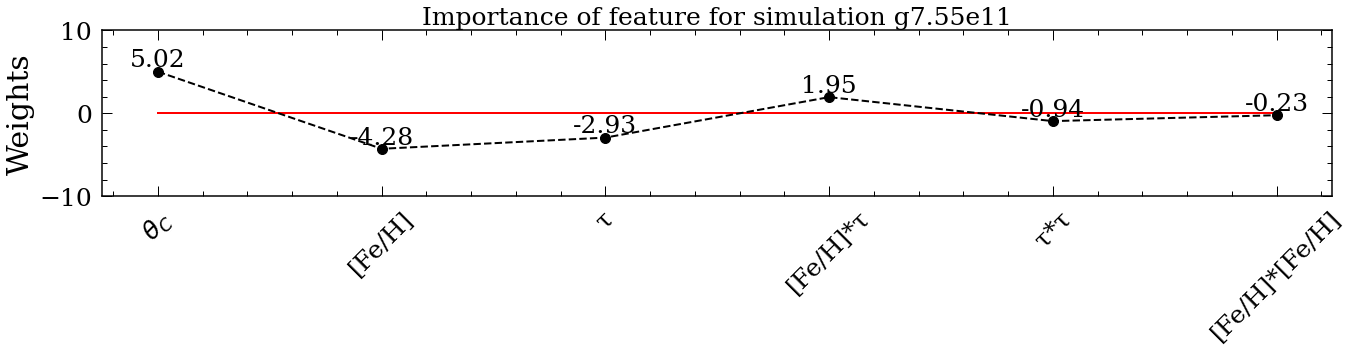

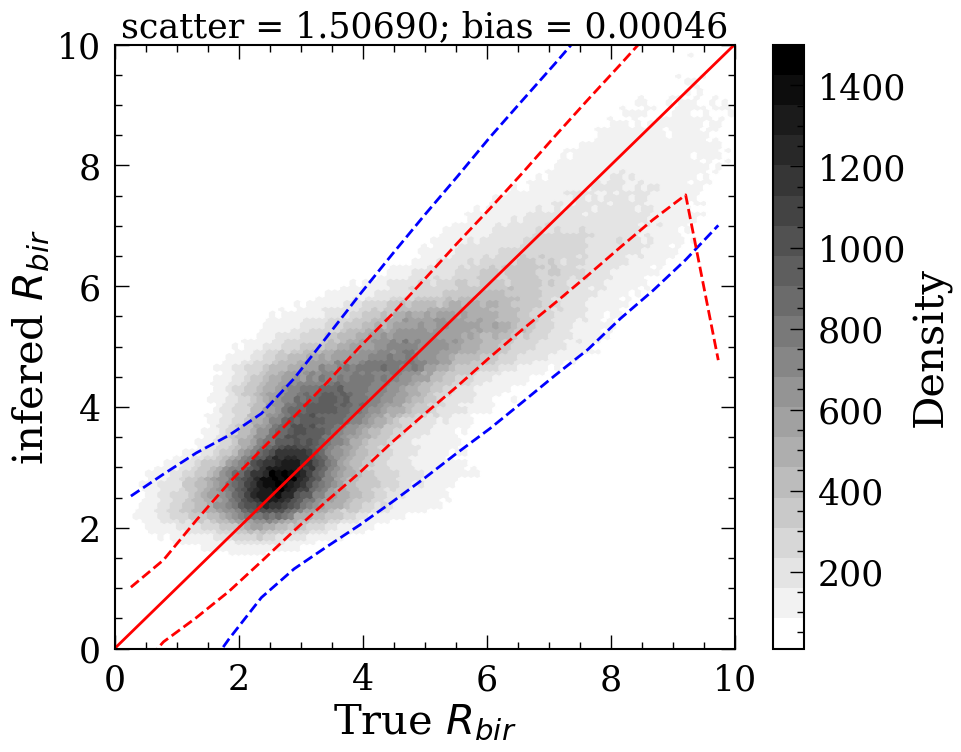

In [40]:
i=-1
simNo=simsnames[i]
Rcut=True
Rcut_thread=15
zcut_thread=5

print('Reading in simulation...')
data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
print('Finished reading in simulation...')

print('Calculating weights...')
allnames, weights, weights_err, y, ypred = calcRbir_cv(data)
print('Finished calculating weights...')


plt.figure(figsize=(19,5))
absweights, weights_imp, weights_imp_err, allnames = zip(*sorted(zip(abs(np.array(weights)), weights, weights_err, allnames)))
weights_imp, allnames = weights_imp[::-1], allnames[::-1]
plt.errorbar(range(len(allnames)), np.array(weights_imp), yerr=np.array(weights_imp_err), fmt='k--o', markersize=10)
plt.plot(range(len(allnames)),np.zeros(len(allnames)),'r-')
plt.xticks(range(len(allnames)), allnames, rotation=45)
#plt.xlabel('Features')
plt.ylabel('Weights')
plt.ylim([-10,10])
plt.title('Importance of feature for simulation g%s'%simsnames[i], fontsize=25)

for j, txt in enumerate(weights_imp):
    txt = np.round(txt,2)
    plt.annotate(txt, (j, weights_imp[j]),size=25,horizontalalignment='center', verticalalignment='bottom')
plt.tight_layout()
plt.savefig(simsnames[i]+'_importance.png')

xs = np.linspace(0, 30, 100)
plt.figure(figsize=(10,8), dpi=100)
scatter = np.std(y-ypred)
bias  = np.mean(y-ypred)
cmap = plt.cm.get_cmap('binary',20)
plt.hexbin(y, ypred, extent=(0,10,0,10),gridsize=100, mincnt=10, cmap=cmap)
Rbirs, Rstds = calcRstd(data)
Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y)
plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
plt.plot(Rbirs, Rbirs-Rstds, 'b--')
plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
plt.plot(xs, xs, "r-")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("True $R_{bir}$")
plt.ylabel("infered $R_{bir}$")
plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
cb = plt.colorbar()
cb.set_label('Density')


  0%|          | 0/6 [00:00<?, ?it/s]

6.96e11
Reading in simulation...
Finished reading in simulation...


 17%|█▋        | 1/6 [00:32<02:42, 32.41s/it]

8.26e11
Reading in simulation...
Finished reading in simulation...


 33%|███▎      | 2/6 [00:54<01:44, 26.16s/it]

7.08e11
Reading in simulation...
Finished reading in simulation...


 50%|█████     | 3/6 [02:35<03:00, 60.24s/it]

2.79e12
Reading in simulation...
Finished reading in simulation...


 83%|████████▎ | 5/6 [04:52<01:04, 64.94s/it]

7.55e11
Reading in simulation...
Finished reading in simulation...


100%|██████████| 6/6 [05:52<00:00, 58.76s/it]


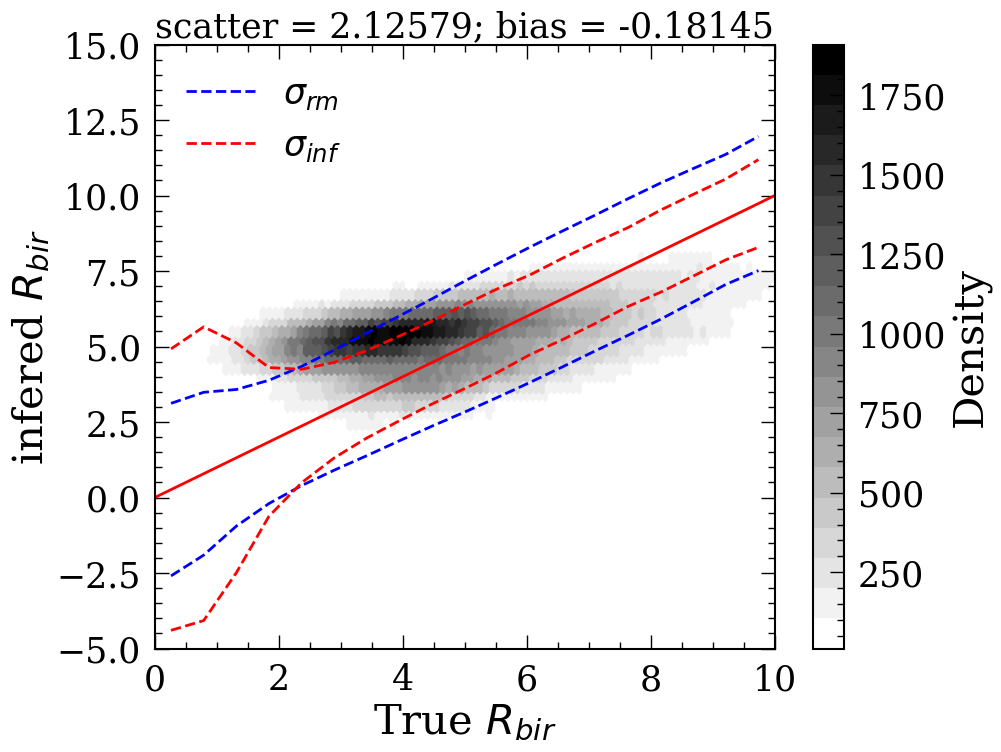

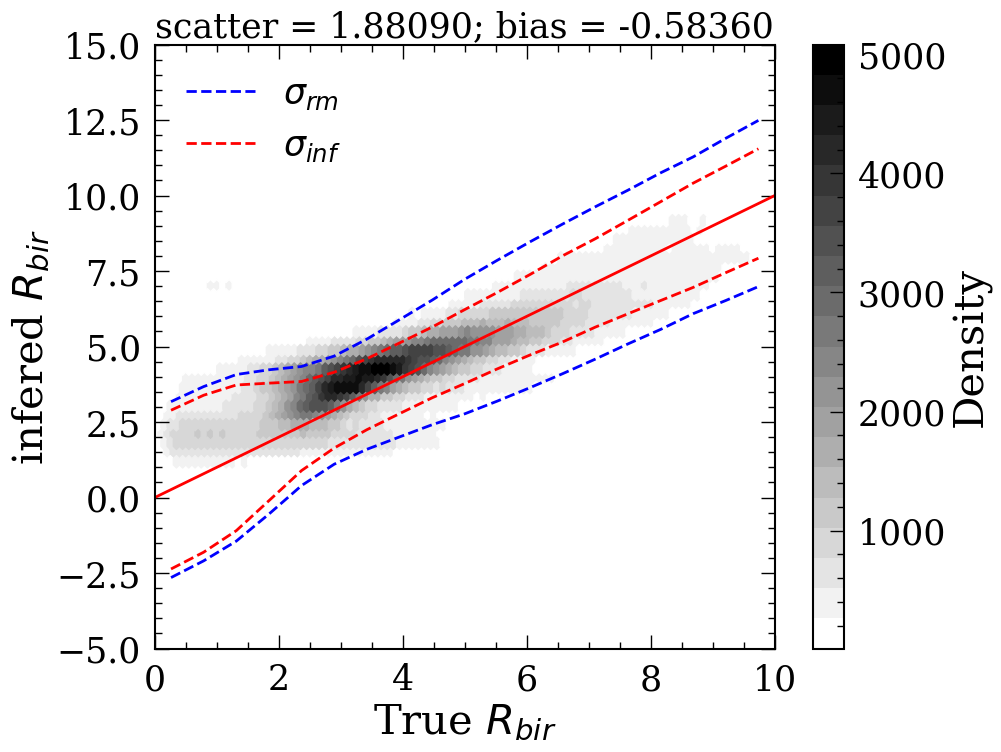

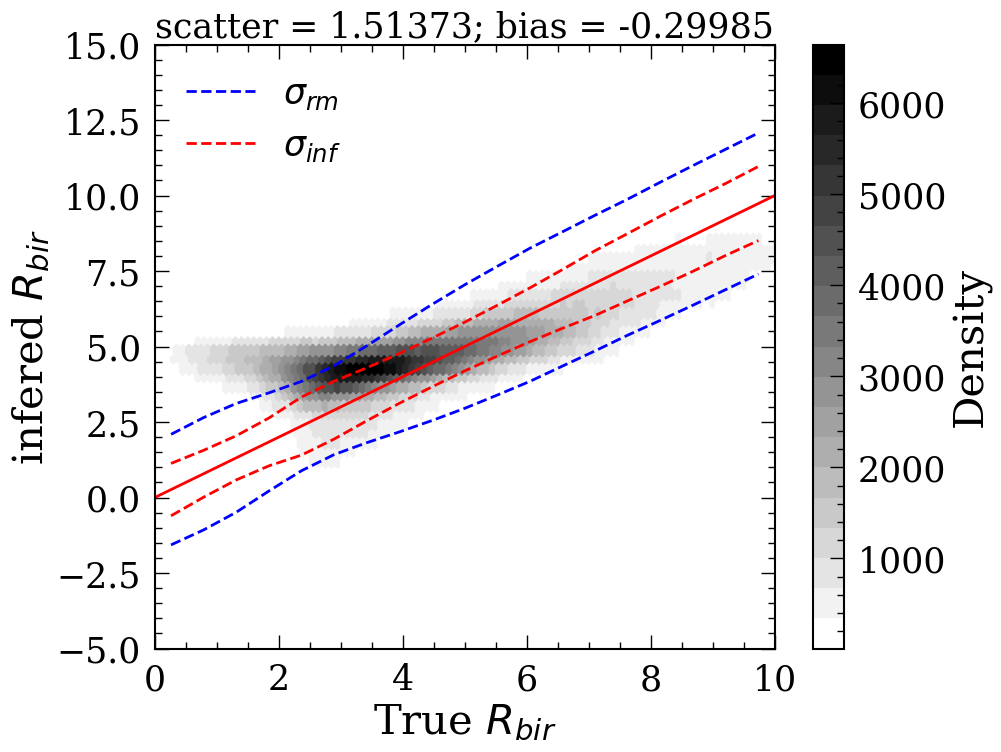

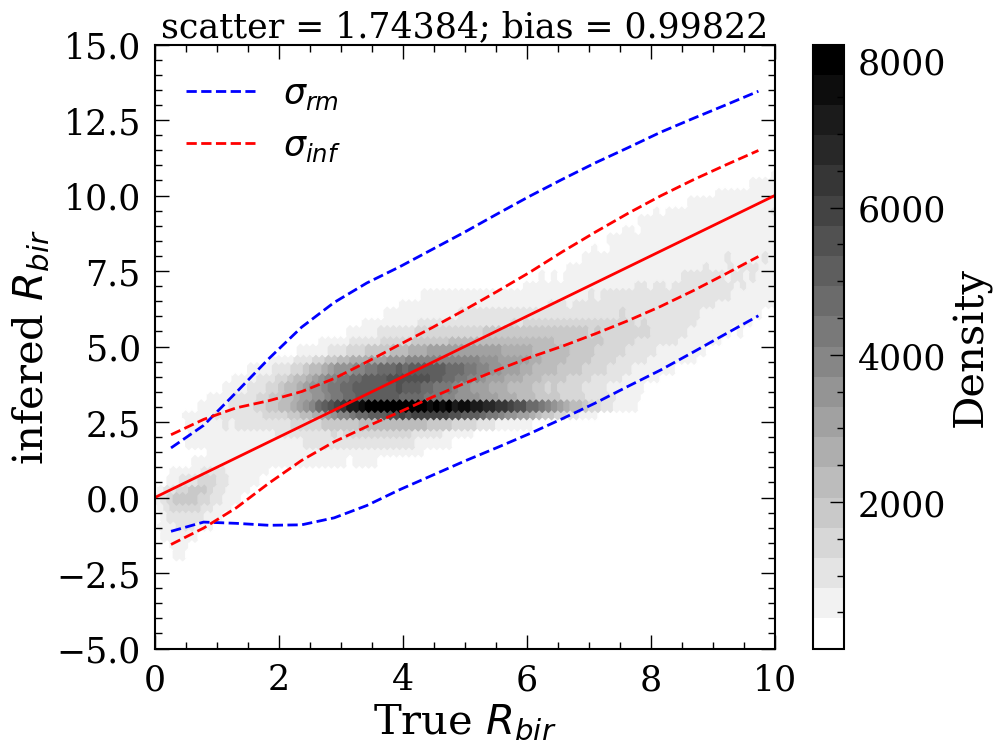

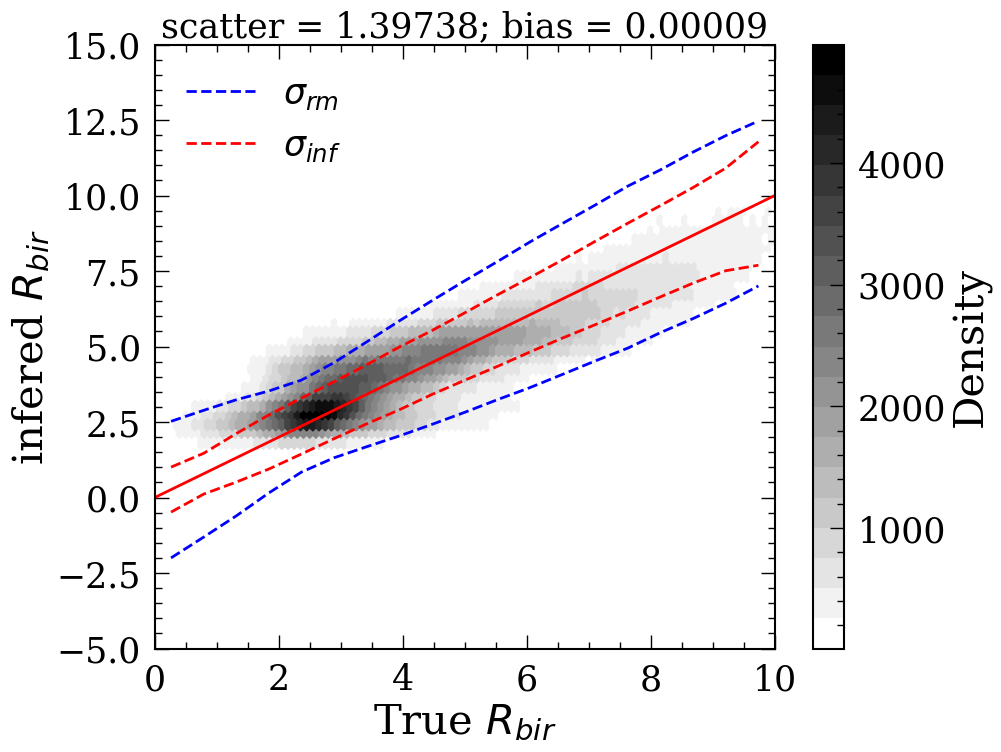

In [41]:
cmap = plt.cm.get_cmap('binary',20)
xs = np.linspace(0, 15, 100)

for i in trange(len(simsnames)):
    if simsnames[i]=='1.12e12':
        continue
    else:
        print(simsnames[i])
        
    simNo=simsnames[i]
    Rcut=True
    Rcut_thread=15
    zcut_thread=5
    
    print('Reading in simulation...')
    data = readsimdata(simNo,Rcut,Rcut_thread,zcut_thread)
    print('Finished reading in simulation...')

    y, ypred = predNew(weights, data)
    
    plt.figure(figsize=(10,8), dpi=100)
    scatter = np.std(y-ypred)
    bias  = np.mean(y-ypred)

    plt.hexbin(y, ypred, extent=(0,10,-20,15),gridsize=100, mincnt=10, cmap=cmap)
    Rbirs, Rstds = calcRstd(data)
    Rbirs_inf, Rstds_inf = calcRstd_inf(ypred, y)
    plt.plot(Rbirs, Rbirs+Rstds, 'b--', label = '$σ_{rm}$')
    plt.plot(Rbirs, Rbirs-Rstds, 'b--')
    plt.plot(Rbirs_inf, Rbirs_inf-Rstds_inf, 'r--', label = '$σ_{inf}$')
    plt.plot(Rbirs_inf, Rbirs_inf+Rstds_inf, 'r--')
    plt.plot(xs, xs, "r-")
    plt.xlim(0, 10)
    plt.ylim(-5, 15)
    plt.xlabel("True $R_{bir}$")
    plt.ylabel("infered $R_{bir}$")
    plt.title('scatter = %.5f; bias = %.5f'%(scatter, bias),fontsize=25)
    plt.legend()
    cb = plt.colorbar()
    cb.set_label('Density')
    plt.savefig(simsnames[i]+'_Rbirth_predW_model'+simsnames[0]+'.png')
    